In [16]:
# main.py
import numpy as np
from tqdm import tqdm
#import gym
#from DDPG_trial import DDPG
from collections import deque
import pdb
import torch
from env import env
from LSTM import LSTMModel  
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt

import pdb 
M, J, N = 2, 3, 4
# Replay Buffer for Experience Replay
class ReplayBuffer:
    def __init__(self, max_size=int(1e6)):
        self.buffer = deque(maxlen=max_size)

    def add(self, state, next_state, action, reward):
        self.buffer.append((state, next_state, action, reward))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, next_state, action, reward = map(np.stack, zip(*batch))
        return (
            torch.FloatTensor(state),
            torch.FloatTensor(next_state),
            torch.FloatTensor(action),
            torch.FloatTensor(reward).unsqueeze(1),
            #torch.FloatTensor(done).unsqueeze(1),
        )

    def size(self):
        return len(self.buffer)

###########generate random discrete matrix for actions(should ideally come from the discretization procedure)


def generate_matrix(N, J):
    # Initialize an NxJ matrix filled with zeros
    matrix = np.zeros((N, J), dtype=int)
    
    # Ensure each column has at least one 1
    for j in range(J):
        # Randomly select a row to place the 1 in column j
        while True:
            row_index = np.random.randint(N)
            # Place the 1 only if that row currently contains no 1
            if np.sum(matrix[row_index]) == 0:
                matrix[row_index, j] = 1
                break
    
    # Fill remaining rows with either a single 1 or all 0s
    for i in range(N):
        if np.sum(matrix[i]) == 0:  # If the row is all zeros
            if np.random.rand() > 0.5:  # 50% chance to add a 1
                col_index = np.random.randint(J)
                matrix[i, col_index] = 1
    
    return matrix


In [17]:
#model = torch.load('LSTM.pth')
# Initialize the model architecture
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model parameters
input_dim = N
hidden_dim = 128
output_dim = N
num_layers = 1

# Initialize the model, loss function and optimizer
model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers).to(device)
#model = LSTMModel()  # Initialize your model with the required parameters

# Load the saved state dictionary
model.load_state_dict(torch.load('LSTM_state_dict_2agents_V1.pth'))


<All keys matched successfully>

In [18]:
Ts = 10000
environ = env(N = N, J = J, M = M, Ts = Ts)
alltime_fast_fading_gains = environ.fast_fading_channel_coefficients()
#alltime_fast_fading_gains = np.load('alltime_fast_fading_gains_2agents.npy')
TxRxds = environ.compute_TxRX()
#TxRxds = np.load('TxRxds_2agents.npy')
alltime_PathGains = environ.large_scale_fading_channel_coefficients(TxRxds)

100%|██████████| 9999/9999 [00:00<00:00, 51326.45it/s]


In [19]:
def get_lstm_pred_SINR(ts_start, ts_end,b = None, interfers_actions = None, b_actions = None):
    history = 10
    SINR_nxt_lstm = np.zeros((J,N))
    for j in range(J):
        inp = []
        for ts in np.arange(ts_start, ts_end):
            SINR =  environ.get_next_state(alltime_PathGains, alltime_fast_fading_gains, ts = ts)[0]
            #pdb.set_trace()
            inp.append(SINR[:,j])
        inp = np.array(inp).reshape(1,history,N)
        SINR_nxt_lstm[j,:] = model(torch.Tensor(inp)).detach().numpy()[0]
    SINR_nxt_lstm = np.transpose(SINR_nxt_lstm)
    #pdb.set_trace()
    return SINR_nxt_lstm


In [20]:
b_prev_actions =  generate_matrix(N, J)
state_lstm = get_lstm_pred_SINR(ts_start = 0, ts_end = 10)
state = np.stack((np.multiply(state_lstm, b_prev_actions),b_prev_actions), axis = 0)
b_prsnt_actions =  generate_matrix(N, J)
nxt_state_lstm = get_lstm_pred_SINR(ts_start = 1, ts_end = 11)
next_state = np.stack((np.multiply(nxt_state_lstm, b_prsnt_actions),b_prsnt_actions), axis = 0)


In [21]:
# Actor Network
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 512)
        #self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(512,256)
        self.fc4 = nn.Linear(256, action_dim)
        self.max_action = max_action

    def forward(self, state):
        #pdb.set_trace()
        x = F.relu(self.fc1(state))
        #x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        #x = self.fc4(x)
        return x * self.max_action

# Critic Network
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 512)
        #self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        #x = state
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        q_value =  self.fc4(x)
        #pdb.set_trace()
        return q_value

In [22]:
# DDPG Agent
class DDPG:
    def __init__(self, state_dim, action_dim, max_action):
        self.actor = Actor(state_dim, action_dim, max_action).to(torch.device("cpu"))
        self.actor_target = Actor(state_dim, action_dim, max_action).to(torch.device("cpu"))
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=0.5e-3)

        self.critic = Critic(state_dim, action_dim).to(torch.device("cpu"))
        self.critic_target = Critic(state_dim, action_dim).to(torch.device("cpu"))
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=0.5e-3)

        self.max_action = max_action
        self.discount = 0.99
        self.tau = 0.005

    def select_action(self, state, noise=0.1):
        state = torch.FloatTensor(state.reshape(1, -1)).to(torch.device("cpu"))
        action = self.actor(state).cpu().data.numpy().flatten()
        action += noise * np.random.normal(0, 1, size=action.shape)  # Add exploration noise
        return action.clip(-self.max_action, self.max_action)  # Clip action to be within bounds

    def train(self, replay_buffer, t, batch_size=64):
        # Sample a batch of transitions from the replay buffer
        state, next_state, action, reward = replay_buffer.sample(batch_size)
        #pdb.set_trace()
        
        #next_state = next_state.view(batch_size,-1)
        #state = state.view(batch_size,-1)
        #action = action.view(batch_size,-1)
        
        next_state = next_state.reshape(batch_size,-1)
        state = state.reshape(batch_size,-1)
        action = action.reshape(batch_size,-1)
        
        # Compute the target Q value
        #pdb.set_trace()
        next_action = self.actor_target(next_state)
        target_q = self.critic_target(next_state, next_action)
        #target_q1, target_q2 = self.critic_target(next_state, next_action)
        #target_q = torch.min(target_q1, target_q2)
        if t < 256:
            not_done = 1.0
        else:
            not_done = 0.0
        #pdb.set_trace()
        target_q = reward + not_done * self.discount * target_q.detach()

        # Get current Q estimate
        current_q = self.critic(state, action)
        #current_q1, current_q2 = self.critic(state, action)
        #current_q = torch.min(current_q1, current_q2)
        # Compute critic loss
        critic_loss = F.mse_loss(current_q, target_q)

        # Optimize the critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Compute actor loss
        actor_loss = -self.critic(state, self.actor(state)).mean()

        # Optimize the actor
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Update the target networks
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

In [23]:
T = 256
############# get initial states  #############
'''
b_prev_actions =  generate_matrix(N, J)
state_lstm = get_lstm_pred_SINR(ts_start = 0, ts_end = 10)
state = np.stack((np.multiply(state_lstm, b_prev_actions),b_prev_actions), axis = 0)
b_prsnt_actions =  generate_matrix(N, J)
nxt_state_lstm = get_lstm_pred_SINR(ts_start = 1, ts_end = 11)
next_state = np.stack((np.multiply(nxt_state_lstm, b_prsnt_actions),b_prsnt_actions), axis = 0)
'''
############################################################
state_dim = 2*N*J
action_dim = N*J
max_action = 1.0
time_slots = np.arange(0,Ts)

agent1 = DDPG(state_dim, action_dim, max_action)
agent2 = DDPG(state_dim, action_dim, max_action)

replay_buffer1 = ReplayBuffer()
replay_buffer2 = ReplayBuffer()

#train_agents(env, agent1, agent2, replay_buffer)
episodes=100
batch_size=64

ts_counter = 0

######## generate interactions dummy ###########
interfers_actions = np.zeros((M-1, J, N)) # should be the actions from other agent. 
for i, m in enumerate(range(M-1)):
    interfers_actions[i,:,:] = np.transpose(generate_matrix(N, J))

In [24]:

def train_agent(agent, state, replay_buffer, episode, ts_counter, b_prev_actions, agent_no = 0):
    
            action = agent.select_action(np.array(state))
            action = return_bin_descrete_action(N,J, np.reshape(action, (N,J)))
            #action = action.flatten()
            #print(action)
            #action =  (action >= 0.5).astype(float)
            #next_state, reward, done, _ = env.step(action)
            nxt_state_lstm = get_lstm_pred_SINR(ts_start = ts_counter+1, ts_end = ts_counter + 11,
                                               b = agent_no, interfers_actions = b_prev_actions, b_actions = action)
            #next_state = np.stack((np.multiply(nxt_state_lstm, action.reshape(N,J)),action.reshape(N,J)), axis = 0)
            next_state = np.stack((nxt_state_lstm,action.reshape(N,J)), axis = 0)
            #next_state = nxt_state_lstm
            
            state = next_state
            ######## generate interactions dummy ###########
            #interfers_actions = np.zeros((M-1, J, N)) # should be the actions from other agent. 
            #for i, m in enumerate(range(M-1)):
                #interfers_actions[i,:,:] = np.transpose(generate_matrix(N, J))
                
            interfers_actions = b_prev_actions.reshape(1, J, N)
            #pdb.set_trace()
    
            '''        
            inter_actions =  (inter_actions >= 0.5).astype(float)
            inter_actions = np.transpose(inter_actions.reshape((N,J)))
            #pdb.set_trace()
            if agent_no == 0:
                interfers_actions[0,:,:] = inter_actions
                
            else:
                interfers_actions[0,:,:] = inter_actions
            #''';
            #reward = np.sum(environ.compute_rewards(alltime_PathGains, alltime_fast_fading_gains, ts = time_slots[ts_counter + 10],
                                                    #b = 0, interfers_actions = interfers_actions, b_actions = b_prev_actions)[2])
            _, p_e, reward = environ.compute_rewards(alltime_PathGains, alltime_fast_fading_gains, ts = time_slots[ts_counter + 10],
                                                    b = agent_no, interfers_actions = interfers_actions, b_actions = action)
            P_e.append(p_e)
            reward = np.mean(reward)
            #print(t, p_e, reward)
            replay_buffer.add(state, next_state, action.reshape(N,J), reward)

            if replay_buffer.size() > batch_size:
                #print('--------------------training----------------')
                agent.train(replay_buffer, t, batch_size)
            ts_counter+=1
            if ts_counter == Ts - 10:
                ts_counter = 0
            #print(ts_counter)
            

            return agent, reward, replay_buffer, state,action,  ts_counter


In [25]:
######### get binary discretized action #########

def return_bin_descrete_action(N,J,uhat):
    u = np.zeros((N,J))
    
    def select_unique_max_indices(matrix):
        
        selected_rows = set()  # To track used row indices
        result_indices = []
    
        # Iterate through each column
        for j in range(J):
            # Sort the row indices by the column values in descending order
            sorted_row_indices = np.argsort(matrix[:, j])[::-1]
            
            # Find the first available row index that has not been selected
            for row in sorted_row_indices:
                if row not in selected_rows:
                    selected_rows.add(row)
                    result_indices.append((row, j))
                    break
        
        return result_indices

    max_indices = select_unique_max_indices(uhat)
    
    # Display the result
    #print(uhat)
    #print("Selected (row, column) indices:", max_indices)
    
    allocated_resos = []
    for ind in max_indices:
        u[ind[0],ind[1]] = 1.0
        allocated_resos.extend([ind[0]])
    unallocated_resos = np.array([r for r in range(N) if r not in allocated_resos])
    
    
    v = np.concatenate((np.zeros((1,J)), np.eye(J)))
    
    
    for r in unallocated_resos:
        ind = np.argmin([np.linalg.norm(uhat[r,:] - v[n,:]) for n in range(v.shape[0])])
        u[r,:] = v[ind,:]
    return u

In [ ]:
#agent_no = 0
#agent1 = DDPG(state_dim, action_dim, max_action)
#replay_buffer1 = ReplayBuffer()
epi_rewards1, epi_rewards2 = [], []
b_prev_actions1, b_prev_actions2 =  generate_matrix(N, J), generate_matrix(N, J)
P_e = []
for episode in range(episodes):
        ############# get initial states  #############
        if episode == 0:
            state_lstm1 = get_lstm_pred_SINR(ts_start = 0, ts_end = 10)
            state_lstm2 = get_lstm_pred_SINR(ts_start = 0, ts_end = 10)
            
        else:
            state_lstm1 = get_lstm_pred_SINR(ts_start = ts_counter, ts_end = ts_counter+10)
            state_lstm2 = get_lstm_pred_SINR(ts_start = ts_counter, ts_end = ts_counter+10)

       
        state1 = np.stack((state_lstm1,b_prev_actions1), axis = 0)
        state2 = np.stack((state_lstm2,b_prev_actions2), axis = 0)
    
        #state1 = state_lstm1
        #state2 = state_lstm2
        #b_prsnt_actions =  generate_matrix(N, J)
        #nxt_state_lstm = get_lstm_pred_SINR(ts_start = 1, ts_end = 11)
        #next_state = np.stack((np.multiply(nxt_state_lstm, b_prsnt_actions),b_prsnt_actions), axis = 0)
        ############################################################
        episode_reward1 = 0
        episode_reward2 = 0
        '''
        for t in range(T):
            agent1, reward1, replay_buffer1, state1, action1, ts_counter = train_agent(agent1, state1, replay_buffer1,
                                                                      episode, ts_counter, b_prev_actions2, agent_no = 0)

            action1 = return_bin_descrete_action(N,J, np.reshape(action1, (N,J)))
            action1 = action1.flatten()
            #print(action1)
            #pdb.set_trace()
            episode_reward1 += reward1
            b_prev_actions1 = action1.reshape(N,J)
            
            agent2, reward2, replay_buffer2, state2, action2, ts_counter = train_agent(agent2, state2, replay_buffer2,
                                                                  episode, ts_counter, b_prev_actions1, agent_no = 1)
            episode_reward2 += reward2
            action2 = return_bin_descrete_action(N,J, np.reshape(action2, (N,J)))
            action2 = action2.flatten()
            b_prev_actions2 = action2.reshape(N,J)
        print(f"Episode: {episode + 1}, Agent1 Reward: {episode_reward1/256}")
        print(f"Episode: {episode + 1}, Agent2 Reward: {episode_reward2/256}")
        ''';

        #'''
        if episode%2 != 0:
            for t in range(T):
                
                    agent1, reward1, replay_buffer1, state1, action1, ts_counter = train_agent(agent1, state1, replay_buffer1,
                                                                      episode, ts_counter, b_prev_actions2, agent_no = 0)

                    action1 = return_bin_descrete_action(N,J, np.reshape(action1, (N,J)))
                    action1 = action1.flatten()
                    #print(action1)
                    #pdb.set_trace()
                    episode_reward1 += reward1
                    b_prev_actions1 = action1.reshape(N,J)
            #print(action1)
            print(f"Episode: {episode + 1}, Agent1 Reward: {episode_reward1/256}")
        else:
            for t in range(T):
                agent2, reward2, replay_buffer2, state2, action2, ts_counter = train_agent(agent2, state2, replay_buffer2,
                                                                  episode, ts_counter, b_prev_actions2, agent_no = 0)
                episode_reward2 += reward2
                action2 = return_bin_descrete_action(N,J, np.reshape(action2, (N,J)))
                action2 = action2.flatten()
                b_prev_actions2 = action2.reshape(N,J)
            #print(action2)
            print(f"Episode: {episode + 1}, Agent2 Reward: {episode_reward2/256}")
            pass
            
        #''';
                
            #episode_reward += reward
            #print(ts_counter)
        #b_prev_actions1 = action.reshape(N,J)
        #print(f"Episode: {episode + 1}, Agent1 Reward: {episode_reward1/256}, Agent2 Reward: {episode_reward2/256}")
        epi_rewards1.append(episode_reward1/256)
        epi_rewards2.append(episode_reward2/256)
epi_rewards1 = np.unique(np.array(epi_rewards1))[1:]
epi_rewards2 = np.unique(np.array(epi_rewards2))[1:]
plt.plot(epi_rewards1)
plt.plot(epi_rewards2)
plt.grid()
plt.show()

Episode: 1, Agent2 Reward: 8.418428858768253
Episode: 2, Agent1 Reward: 8.3221527845172
Episode: 3, Agent2 Reward: 8.916528147815756
Episode: 4, Agent1 Reward: 7.215067734786812
Episode: 5, Agent2 Reward: 8.84380450587277
Episode: 6, Agent1 Reward: 10.0
Episode: 7, Agent2 Reward: 8.803804130122218
Episode: 8, Agent1 Reward: 9.389033043269846
Episode: 9, Agent2 Reward: 8.82946831338758
Episode: 10, Agent1 Reward: 9.45155097255303
Episode: 11, Agent2 Reward: 8.741889116558772
Episode: 12, Agent1 Reward: 10.0
Episode: 13, Agent2 Reward: 8.642048053484658
Episode: 14, Agent1 Reward: 7.494810561867579
Episode: 15, Agent2 Reward: 8.845229546378182
Episode: 16, Agent1 Reward: 9.563965555285682
Episode: 17, Agent2 Reward: 8.916491800209604
Episode: 18, Agent1 Reward: 7.085730593359561
Episode: 19, Agent2 Reward: 8.838354020206294
Episode: 20, Agent1 Reward: 10.0
Episode: 21, Agent2 Reward: 8.945244513243795
Episode: 22, Agent1 Reward: 10.0
Episode: 23, Agent2 Reward: 8.908298243613102
Episode:

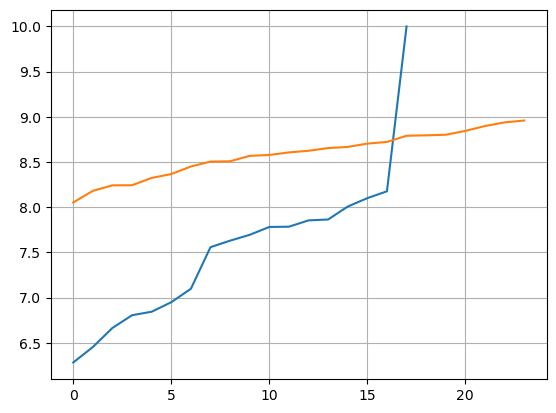

In [ ]:
P_e = np.arange(1e-20,1e-4, 1e-5)
P_o = 1e-5
epsilon = 1e-30
reward = -np.log10(np.abs(((P_e/P_o)+epsilon)))
#reward = -np.exp((P_e/P_o) - 1)
plt.grid()
plt.semilogy(reward, P_e)

In [ ]:
np.unique(np.array(epi_rewards2))[1:]

In [ ]:
#epi_rewards1 = np.load('agents1_rewards_400.npy')
#epi_rewards2 = np.load('agents2_rewards_400.npy')

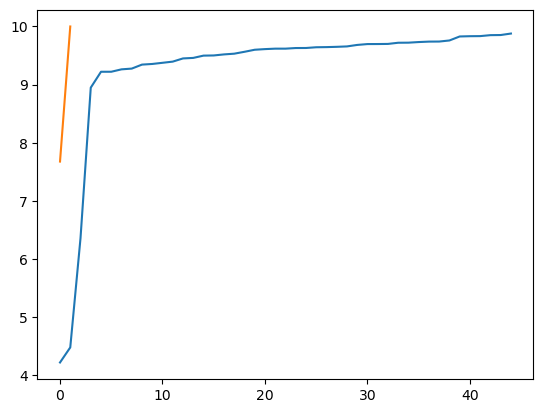

In [12]:
#plt.plot(epi_rewards1)
plt.plot(np.unique(np.array(epi_rewards2))[1:])
plt.plot(np.unique(np.array(epi_rewards1))[1:])
plt.show()

In [ ]:
import pandas as pd
plt.figure(1)
df = pd.DataFrame({'values':np.unique(np.array(epi_rewards1))[1:]})
df['rolling_mean'] = df['values'].rolling(window = 30).mean()
plt.plot(df['rolling_mean'])
plt.figure(2)
df = pd.DataFrame({'values':np.unique(np.array(epi_rewards2))[1:]})
df['rolling_mean'] = df['values'].rolling(window = 30).mean()
plt.plot(df['rolling_mean'])

In [ ]:
df

In [ ]:
P_e = np.arange(1e-15,1e-5, 1e-8)
P_o = 1e-5
reward = -np.log10(np.abs(((P_e/P_o)+1e-15)))
plt.plot(P_e, reward)

In [ ]:
agent_no = 0
agent = DDPG(state_dim, action_dim, max_action)
replay_buffer = ReplayBuffer()
epi_rewards1, epi_rewards2 = [], []
b_prev_actions1, b_prev_actions2 =  generate_matrix(N, J), generate_matrix(N, J)
P_e = []
for episode in range(episodes):
        ############# get initial states  #############
        if episode == 0:
            state_lstm1 = get_lstm_pred_SINR(ts_start = 0, ts_end = 10)
            state_lstm2 = get_lstm_pred_SINR(ts_start = 0, ts_end = 10)
            
        else:
            state_lstm1 = get_lstm_pred_SINR(ts_start = ts_counter, ts_end = ts_counter+10)
            state_lstm2 = get_lstm_pred_SINR(ts_start = ts_counter, ts_end = ts_counter+10)

        #state = np.stack((np.multiply(state_lstm, b_prev_actions),b_prev_actions), axis = 0)
        state1 = np.stack((state_lstm1,b_prev_actions1), axis = 0)
        state2 = np.stack((state_lstm2,b_prev_actions2), axis = 0)

        #b_prsnt_actions =  generate_matrix(N, J)
        #nxt_state_lstm = get_lstm_pred_SINR(ts_start = 1, ts_end = 11)
        #next_state = np.stack((np.multiply(nxt_state_lstm, b_prsnt_actions),b_prsnt_actions), axis = 0)
        ############################################################
        episode_reward1 = 0
        episode_reward2 = 0
        
        if episode%1 == 0:
            print(episode)
            for t in range(T):
                    #agent1, reward1, replay_buffer1, state1, action1, ts_counter = train_agent(agent1, state1,replay_buffer1,
                                                                      #episode, ts_counter, b_prev_actions2, agent_no = 0)
                    #'''
                    action = agent.select_action(np.array(state))
    
                    nxt_state_lstm = get_lstm_pred_SINR(ts_start = ts_counter+1, ts_end = ts_counter + 11)
                    #next_state = np.stack((np.multiply(nxt_state_lstm, action.reshape(N,J)),action.reshape(N,J)), axis = 0)
                    next_state = np.stack((nxt_state_lstm,action.reshape(N,J)), axis = 0)
                
                
                    state = next_state
                    ######## generate interactions dummy ###########
                    interfers_actions = np.zeros((M-1, J, N)) # should be the actions from other agent. 
                    for i, m in enumerate(range(M-1)):
                        interfers_actions[i,:,:] = np.transpose(generate_matrix(N, J))
                    
               
                    #inter_actions =  (inter_actions >= 0.5).astype(float)
                    #inter_actions = np.transpose(inter_actions.reshape((N,J)))
                    #if agent_no == 0:
                        #interfers_actions[1,:,:] = inter_actions
                    #else:
                        #interfers_actions[0,:,:] = inter_actions
             
                    #reward = np.sum(environ.compute_rewards(alltime_PathGains, alltime_fast_fading_gains, ts = time_slots[ts_counter + 10],
                                                            #b = 0, interfers_actions = interfers_actions, b_actions = b_prev_actions)[2])
                    _, p_e, reward = environ.compute_rewards(alltime_PathGains, alltime_fast_fading_gains, ts = time_slots[ts_counter + 10],
                                                            b = agent_no, interfers_actions = interfers_actions, b_actions = b_prev_actions)
                    P_e.append(p_e)
                    reward = np.sum(reward)
                    #print(t, p_e, reward)
                    replay_buffer.add(state, next_state, action.reshape(N,J), reward)
    
                    if replay_buffer.size() > batch_size:
                        agent.train(replay_buffer, t, batch_size)
                    ts_counter+=1
                    if ts_counter == Ts - 10:
                        ts_counter = 0
                    #''';
                    episode_reward1 += reward
                    b_prev_actions = action.reshape(N,J)
            print(f"Episode: {episode + 1}, Agent1 Reward: {episode_reward1/256}")
        else:
            #for t in range(T):
                #agent2, reward2, replay_buffer2, state2, action2, ts_counter = train_agent(agent2, state2,replay_buffer2,
                                                                  #episode, ts_counter, b_prev_actions1, agent_no = 1)
                #episode_reward2 += reward2
                #b_prev_actions2 = action2.reshape(N,J)
            #print(f"Episode: {episode + 1}, Agent2 Reward: {episode_reward2/256}")
            pass
            
        
        '''
        for t in range(T):
            if t%2 == 0:
                agent1, reward1, replay_buffer1, state1, action1, ts_counter = train_agent(agent1, state1,replay_buffer1,
                                                                  t, ts_counter, b_prev_actions2, agent_no = 0)
                episode_reward1 += reward1
                b_prev_actions1 = action1.reshape(N,J)

            else:
                agent2, reward2, replay_buffer2, state2, action2, ts_counter = train_agent(agent2, state2,replay_buffer2,
                                                                  t, ts_counter, b_prev_actions1, agent_no = 1)
                episode_reward2 += reward2
                b_prev_actions2 = action2.reshape(N,J)
         ''';
                
            #episode_reward += reward
            #print(ts_counter)
        #b_prev_actions1 = action.reshape(N,J)
        #print(f"Episode: {episode + 1}, Agent1 Reward: {episode_reward1/256}, Agent2 Reward: {episode_reward2/256}")
        epi_rewards1.append(episode_reward1/256)
        #epi_rewards2.append(episode_reward2/256)

In [ ]:
plt.plot(epi_rewards1)
#plt.plot(epi_rewards2)
plt.show()

In [ ]:
import pandas as pd
df = pd.DataFrame({'values':epi_rewards1})
df['rolling_mean'] = df['values'].rolling(window = 120).mean()
plt.plot(df['rolling_mean'])